In [1]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_files
import re
import glob
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
import pickle
from nltk.corpus import stopwords
import sys
from functools import partial
from zipfile import ZipFile

[nltk_data] Error loading stopwords: HTTP Error 401: Authorization
[nltk_data]     Required
[nltk_data] Error loading wordnet: HTTP Error 401: Authorization
[nltk_data]     Required


In [2]:
data = []
with ZipFile("data.zip") as z:
    for fname in z.namelist():
        if not fname.endswith('.txt') or not fname.startswith('data'):
            continue
        content = z.read(fname).decode('utf8')
        label, idx = fname[5:-4].split('-', 1)
        data.append((idx,label,content,))
df_train = pd.DataFrame(data, columns=("id", "label", "content"))
df_train.sample(10)

,id,label,content
1890,15960,employment,THIRD AMENDMENT\n\nTO\n\n\n\nThis AMENDMENT TO...
2282,18490,rsu,\n\n\n* * *\n\nExhibit 10.3\n\n \n\n\n \n\...
2632,21990,rsu,Exhibit 10.10 \n\nGrant No.:\n\nCAPITALSOURCE ...
398,43480,bylaws,"EXHIBIT 3B \n\n\n\nOF\n\nASTRO-MED, INC. \n\n(..."
1533,12390,employment,\n\n\nExhibit 99.1\n\n\n\nTHIS AGREEMENT is ...
3560,31270,rsu,Exhibit 10.3\n\n\n\nOPTION AGREEMENT (this “Op...
2745,23120,rsu,\n\n\nEXHIBIT 10.4\n\nINTERNATIONAL RECTIFIE...
4244,00010,SPA,Exhibit 10.19\n\n\n\n \n\n\nTHIS SHARE PURCHA...
2463,20300,rsu,Exhibit 10.9\n\nSARA CREEK GOLD CORP.\n\n2014 ...
1892,15980,employment,Exhibit 10.3 Employment Agreement between Firs...


In [3]:
# Read the train data
#train_data = load_files(r'data', categories=['bylaws', 'credit', 'employment', 'rra', 'rsu', 'spa'])

In [4]:
#X, y = train_data.data, train_data.target_names
#print(y[0])

X = df_train['content'].to_list()

y_data = df_train['label'].to_list()


In [5]:
# Txt preprocessing
documents = []

from nltk.stem import WordNetLemmatizer

stemmer = WordNetLemmatizer()

for sen in range(0, len(X)):
    # Remove all the special characters
    document = re.sub(r'\W', ' ', str(X[sen]))
    
    # remove all single characters
    document = re.sub(r'\s+[a-zA-Z]\s+', ' ', document)
    
    # Remove single characters from the start
    document = re.sub(r'\^[a-zA-Z]\s+', ' ', document) 
    
    # Substituting multiple spaces with single space
    document = re.sub(r'\s+', ' ', document, flags=re.I)
    
    # Removing prefixed 'b'
    document = re.sub(r'^b\s+', '', document)
    
    # Converting to Lowercase
    document = document.lower()
    
    # Lemmatization
    document = document.split()

    document = [stemmer.lemmatize(word) for word in document]
    document = ' '.join(document)
    
    documents.append(document)

In [6]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(max_features=1500, min_df=5, max_df=0.7, stop_words=stopwords.words('english'))
X_data = vectorizer.fit_transform(documents).toarray()

In [7]:
from sklearn.feature_extraction.text import TfidfTransformer

tfidfconverter = TfidfTransformer()
X_data = tfidfconverter.fit_transform(X_data).toarray()

In [8]:
from sklearn.model_selection import train_test_split 

X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2, random_state=0)

In [9]:
from sklearn.ensemble import RandomForestClassifier

classifier = RandomForestClassifier(n_estimators=1500, random_state=0)
classifier.fit(X_train, y_train) 

y_pred = classifier.predict(X_test)


AxesSubplot(0.125,0.125;0.775x0.755)


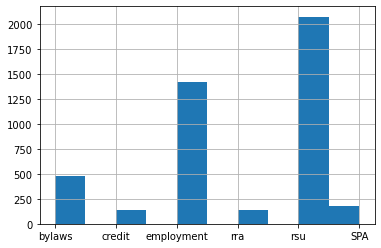

In [10]:
print(df_train.label.hist())

In [11]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))
print(accuracy_score(y_test, y_pred))

[[ 35   0   0   0   0   3]
 [  0  83   0   0   0   0]
 [  1   0  39   0   0   2]
 [  0   0   0 278   0   1]
 [  0   1   0   0  26   1]
 [  1   0   0   1   0 414]]
              precision    recall  f1-score   support

         SPA       0.95      0.92      0.93        38
      bylaws       0.99      1.00      0.99        83
      credit       1.00      0.93      0.96        42
  employment       1.00      1.00      1.00       279
         rra       1.00      0.93      0.96        28
         rsu       0.98      1.00      0.99       416

    accuracy                           0.99       886
   macro avg       0.99      0.96      0.97       886
weighted avg       0.99      0.99      0.99       886

0.9875846501128668


In [12]:
# Read the test data

data = []
with ZipFile("test.zip") as z:
    for fname in z.namelist():
        content = z.read(fname).decode('utf8')
        if not fname.endswith('.txt') or not fname.startswith('test'):
            continue
        idx = fname[5:-4]
        data.append((idx,content,))
df_test = pd.DataFrame(data, columns=("id", "content"))
df_test.sample(10)

X_test_data = df_test['content'].to_list()


In [13]:
print(df_test.head())

      id                                            content
0  acldm  Exhibit 10.4\n\nCAPITAL TRUST, INC.\n\n2007 LO...
1  acxlg    \n\n\n  \n\n\n  \n\n\n  \n\n\n  \n\n\n  \n\n...
2  aehlr  Exhibit 99.3\n\nHERBALIFE LTD.  \n2004 STOCK I...
3  aerlh  Exhibit 10.10\n\n\n\nTHIS STOCK OPTION AGREEME...
4  aisgb  Exhibit 10.6\n\n\n\nEMPLOYMENT AGREEMENT effec...


In [14]:
# Txt preprocessing
documents = []

from nltk.stem import WordNetLemmatizer

stemmer = WordNetLemmatizer()

for sen in range(0, len(X_test_data)):
    # Remove all the special characters
    document = re.sub(r'\W', ' ', str(X_test_data[sen]))
    
    # remove all single characters
    document = re.sub(r'\s+[a-zA-Z]\s+', ' ', document)
    
    # Remove single characters from the start
    document = re.sub(r'\^[a-zA-Z]\s+', ' ', document) 
    
    # Substituting multiple spaces with single space
    document = re.sub(r'\s+', ' ', document, flags=re.I)
    
    # Removing prefixed 'b'
    document = re.sub(r'^b\s+', '', document)
    
    # Converting to Lowercase
    document = document.lower()
    
    # Lemmatization
    document = document.split()

    document = [stemmer.lemmatize(word) for word in document]
    document = ' '.join(document)
    
    documents.append(document)

In [15]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(max_features=1500, min_df=5, max_df=0.7, stop_words=stopwords.words('english'))
X_test_data = vectorizer.fit_transform(documents).toarray()

In [16]:
from sklearn.feature_extraction.text import TfidfTransformer

tfidfconverter = TfidfTransformer()
X_test_data = tfidfconverter.fit_transform(X_test_data).toarray()

In [17]:
y_pred = classifier.predict(X_test_data)


AxesSubplot(0.125,0.125;0.775x0.755)


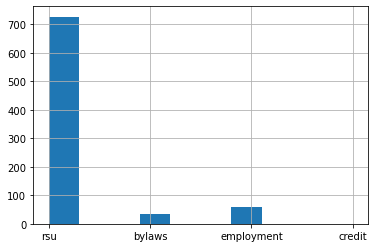

In [18]:
df_test['label'] = y_pred
print(df_test.label.hist())

In [19]:
import sys
from functools import partial
from zipfile import ZipFile
import pandas as pd
sys.path.append('../src')
%matplotlib inline

In [20]:
from urllib import request, parse
import json, random

def submit(name,company,email,phone,user, test_data):
    """Submits a test data set to the pydata server, and returns accuracy"""
    try:
        test_data = {str(k).lower().replace(".txt", ""):str(v).lower().strip() for k,v in test_data.items()}
        data = parse.urlencode({"user":user, "submission": json.dumps(test_data), "name":name,"company":company,"phone":phone,"email":email}).encode()
        req =  request.Request("https://goren.ml/uattcontract/index.php?rand="+str(random.randint(167,1000000)), data=data)
        resp = request.urlopen(req)
        return float(resp.read().decode("utf8"))
    except Exception as e:
        print (str(e))
        return None

In [21]:
# If you're having problem importing this file, copy and paste the contents of "uatt.py" in this cell instead
# of the import statement
#from uatt import submit

my_submit = partial(submit, "Nir Cohen", "IAI", "nir.cohen13@gmail.com", "0546840888")

In [22]:
submission = dict(df_test[["id","label"]].values)
#submission name must be unique
submission_name = "Nir_Cohen_1"
my_submit(submission_name, submission)

0.52798053527981

In [23]:
# Save model
#with open('text_classifier', 'wb') as picklefile:
#    pickle.dump(classifier,picklefile)

In [24]:
# Read the test data

#data = []
#with ZipFile("test.zip") as z:
#    for fname in z.namelist():
#        content = z.read(fname).decode('utf8')
#        if not fname.endswith('.txt') or not fname.startswith('test'):
#            continue
#        idx = fname[5:-4]
#        data.append((idx,content,))
#df_test = pd.DataFrame(data, columns=("id", "content"))
#df_test.sample(10)

#X_test = df_test['content'].to_list()


#path = os.path.dirname('C:\Users\nirco\contract_classification\notebooks\test')
#csv_files = glob.glob(os.path.join(path, "*.csv"))

#csv_files = glob.glob('test')

#train_data = load_files(r'test')
#X_test = train_data.data

# List comprehension that loads of all the files
# X_test = [pd.read_csv(x) for x in path]

